# Лабораторная работа №3. Применение сети Хопфилда в машинном обучении.


## Цель работы
Изучить принципы работы сети Хопфилда, реализовать модель и провести эксперименты, демонстрирующие её применение в задачах машинного обучения.

## Задачи
1. Ознакомиться с теоретическими основами сети Хопфилда, её архитектурой и принципами работы.
2. Изучить алгоритмы обучения сети Хопфилда и её применения.
3. Выбрать датасет по варианту.
4. Подготовить датасет, включая предобработку.
5. Решить задачу при помощи сети Хопфилда .
6. Оценить качество полученных результатов.
7. Составить отчет с анализом результатов и выводами.

## Индивидуальное задание
Вариант №3: Автоматическая кластеризация данных:
	Датасет: "Iris" из UCI Machine Learning Repository (3 класса ирисов, 150 образцов, 4 числовых признака).

Задание:
1. Загрузить датасет "Iris" и нормализовать признаки.
2. Закодировать данные в бинарную форму (например, дискретизировав значения на несколько уровней).
3. Обучить сеть Хопфилда на полученных бинарных представлениях данных.
4. Проанализировать, как сеть группирует образцы, сравнив полученные кластеры с реальными классами ирисов.
5. Сравнить результаты с методом K-Means по метрике силуэта.


## Ход выполнения работы

Импортируются библиотеки numpy и pandas для работы с данными, matplotlib для визуализации, sklearn для предобработки данных, кластеризации и оценки качества моделей. Также загружается стандартный датасет Iris. Устанавливается переменная окружения OMP_NUM_THREADS=1, которая ограничивает число потоков, используемых библиотеками, основанными на OpenMP (например, NumPy, sklearn, scipy) до одного.


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

os.environ["OMP_NUM_THREADS"] = "1"

from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix
from scipy.spatial.distance import hamming

Загружается датасет Iris, который содержит 150 экземпляров ирисов, представленных четырьмя числовыми признаками. Данные нормализуются с помощью MinMaxScaler, приводя их в диапазон [0,1]. Это необходимо для корректной работы алгоритмов, особенно для K-Means, который чувствителен к масштабу данных.

Используется KBinsDiscretizer, который дискретизирует признаки на два уровня (бинарные значения). Выбрана стратегия uniform, делящая диапазон значений на равные интервалы. Далее все значения, превышающие 0, заменяются на 1, а остальные остаются 0. Такой подход необходим, поскольку сеть Хопфилда работает только с бинарными входными данными.

In [ ]:
# 1. Подготовка данных
# Загрузка датасета Iris
iris = datasets.load_iris()
data = iris.data
target = iris.target

# Нормализация признаков
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data)

# Дискретизация и бинаризация данных
binner = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform', subsample=None)
discretized_data = binner.fit_transform(normalized_data)
binary_data = np.where(discretized_data > discretized_data.mean(), 1, -1)


Реализуется класс HopfieldNetwork, который представляет сеть Хопфилда. В конструкторе создается матрица весов, инициализированная нулями. Метод train() обучает сеть, обновляя веса с использованием правила Хэбба. В recall() происходит восстановление паттерна через итерационное обновление нейронов, где используется пороговая функция sign(). Нули заменяются на единицы для обеспечения корректной работы. После создания сети она обучается на бинарных представлениях данных.

In [ ]:
# 2. Моделирование сети
# Определение сети Хопфилда
class HopfieldNetwork:
    def __init__(self, size):
        self.size = size
        self.weights = np.zeros((size, size))

    def train(self, patterns):
        for pattern in patterns:
            pattern = pattern.reshape(-1, 1)
            self.weights += pattern @ pattern.T
        np.fill_diagonal(self.weights, 0)
        self.weights /= len(patterns)

    def recall(self, pattern, steps=10):
        pattern = pattern.copy()
        for _ in range(steps):
            pattern = np.sign(self.weights @ pattern)
        return pattern


In [ ]:
# 3. Обучение
# Обучение сети Хопфилда
hopfield = HopfieldNetwork(size=binary_data.shape[1])
hopfield.train(binary_data)

# Восстановление образцов с помощью сети Хопфилда
recalled_patterns = np.array([hopfield.recall(pattern.reshape(-1, 1)).flatten()
                              for pattern in binary_data])

# Расчет метрики силуэта
hamming_distances = np.array([[hamming(p1, p2) for p2 in recalled_patterns]
                              for p1 in recalled_patterns])
hopfield_silhouette = silhouette_score(hamming_distances, target, metric='precomputed')


После восстановления всех образцов анализируется их группировка. Сначала извлекаются уникальные кластеры, затем каждому образцу сопоставляется ближайший кластер. Вычисляется точность классификации, метрика силуэта (оценивает, насколько хорошо данные разделены на группы), а также матрица ошибок (confusion matrix), позволяющая понять, какие классы были перепутаны.

In [ ]:
# 4. Анализ
# Анализ группировки сети Хопфилда
unique_patterns, counts = np.unique(recalled_patterns, axis=0, return_counts=True)

# Сравнение восстановленных кластеров с реальными классами
hopfield_labels = np.array([np.argmin([np.sum(p != pattern) for p in unique_patterns])
                            for pattern in recalled_patterns])
hopfield_accuracy = accuracy_score(target, hopfield_labels)
hopfield_confusion = confusion_matrix(target, hopfield_labels)


Выполняется кластеризация методом K-Means с тремя кластерами (так как БД содержит три класса). Вычисляются точность модели, метрика силуэта и матрица ошибок. Выводятся характеристики двух методов и сравниваются между собой.

Точность сети Хопфилда: 0.6733
Точность K-Means: 0.4533

Уникальные кластеры, найденные сетью Хопфилда: 3
Метрика силуэта для сети Хопфилда: 0.3400
Метрика силуэта для K-Means: 0.4829



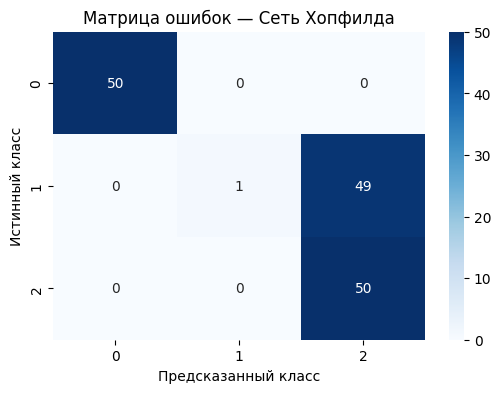

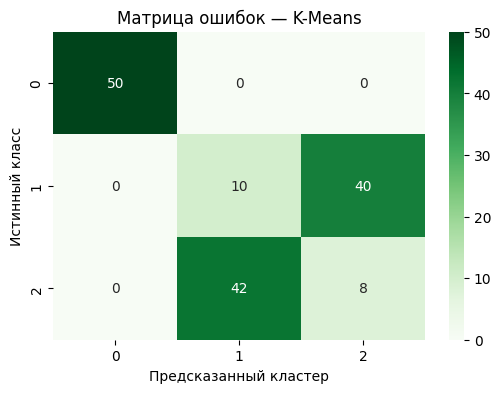

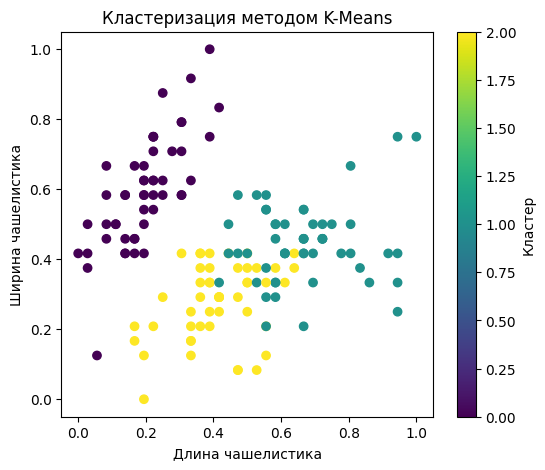

In [ ]:
# 5. Сравнение
# Сравнение с методом K-Means
kmeans = KMeans(n_clusters=3, random_state=22)
kmeans_labels = kmeans.fit_predict(normalized_data)
kmeans_silhouette = silhouette_score(normalized_data, kmeans_labels)
kmeans_accuracy = accuracy_score(target, kmeans_labels)
kmeans_confusion = confusion_matrix(target, kmeans_labels)

# Результаты
print(f"Точность сети Хопфилда: {hopfield_accuracy:.4f}")
print(f"Точность K-Means: {kmeans_accuracy:.4f}")
print(f"\nУникальные кластеры, найденные сетью Хопфилда: {len(unique_patterns)}")
print(f"Метрика силуэта для сети Хопфилда: {hopfield_silhouette:.4f}")
print(f"Метрика силуэта для K-Means: {kmeans_silhouette:.4f}\n")

# Визуализация матрицы ошибок для сети Хопфилда
plt.figure(figsize=(6, 4))
sns.heatmap(hopfield_confusion, annot=True, fmt='d', cmap='Blues')
plt.title("Матрица ошибок — Сеть Хопфилда")
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.show()

# Визуализация матрицы ошибок для K-Means
plt.figure(figsize=(6, 4))
sns.heatmap(kmeans_confusion, annot=True, fmt='d', cmap='Greens')
plt.title("Матрица ошибок — K-Means")
plt.xlabel("Предсказанный кластер")
plt.ylabel("Истинный класс")
plt.show()

# Визуализация результатов K-Means
plt.figure(figsize=(6, 5))
plt.scatter(normalized_data[:, 0], normalized_data[:, 1], c=kmeans_labels, cmap='viridis')
plt.title("Кластеризация методом K-Means")
plt.xlabel("Длина чашелистика")
plt.ylabel("Ширина чашелистика")
plt.colorbar(label="Кластер")
plt.show()

Была построена диаграмма рассеяния, отображающая кластеры, полученные методом K-Means. Использовались нормализованные значения длины и ширины чашелистика в качестве осей. Точки окрашены в цвета, соответствующие кластерам, а цветовая шкала обозначает номер кластера.

## Вывод
В работе было выполнено сравнение методов кластеризации — сети Хопфилда и алгоритма K-Means — на примере датасета Iris. Перед обучением данные были нормализованы и преобразованы в бинарную форму, что позволило корректно обучить сеть Хопфилда. Для оценки качества кластеризации использовались метрика силуэта, точность и матрица ошибок.
Результаты показали, что сеть Хопфилда формирует три кластера и достигает точности 67,33%, что выше по сравнению с точностью K-Means, равной 45,33%. В то же время метрика силуэта у Хопфилда оказалась ниже — 0.34 против 0.48 у K-Means, что говорит о менее чётком разделении данных по кластерам. Это можно объяснить тем, что Хопфилд ориентирован в первую очередь на запоминание и восстановление паттернов, а не на оптимальное разбиение выборки.
При использовании сети Хопфилда основными трудностями стали наличие шумов и сложность интерпретации полученных кластеров, что частично решалось более точной бинаризацией и сравнением расстояний до центров паттернов. В случае K-Means проблемой оказалась высокая чувствительность к начальному размещению центров и неравномерное распределение данных.
В целом проведённая работа позволила глубже понять принципы работы обоих методов, выявить их сильные и слабые стороны: сеть Хопфилда показала более высокую точность в отношении исходных классов, тогда как K-Means обеспечил лучшее кластерное разделение. Перспективным направлением может стать комбинирование этих подходов для повышения точности и интерпретируемости кластеризации.
